# Handling Realworld data in Pytorch

## Images

In [33]:
import numpy as np
import imageio
import torch
import os
from torchvision import transforms
from PIL import Image

In [3]:
img_arr = imageio.imread('/Users/user/Desktop/dog_test.jpg')

In [4]:
img_arr.shape

(825, 800, 3)

In [5]:
type(img_arr)

imageio.core.util.Array

### Changing the Layout
the present shape is HxWxC we will now conver it into CxHxW

In [9]:
img = torch.from_numpy(img_arr)
img.shape

torch.Size([825, 800, 3])

In [11]:
out = img.permute(2,0,1)
out.shape

torch.Size([3, 825, 800])

In [23]:
help(torch.permute)

Help on built-in function permute:

permute(...)
    permute(input, dims) -> Tensor
    
    Returns a view of the original tensor :attr:`input` with its dimensions permuted.
    
    Args:
        {input}
        dims (tuple of ints): The desired ordering of dimensions
    
    Example:
        >>> x = torch.randn(2, 3, 5)
        >>> x.size()
        torch.Size([2, 3, 5])
        >>> torch.permute(x, (2, 0, 1)).size()
        torch.Size([5, 2, 3])



**NOTE: ** out uses the same underlying storage as img and only plays with the size and stride information at the tensor level. This makes the operation chep, but we need to be careful as any change in img would reflect in out.

Batch Dimensions: NxCxHxW

where:
- N: Batch size
- C: Channels
- H: Height of image/number of rows
- W: Width of image/nuumber of columns


In [42]:
# dummy dir
data_dir = r'/Users/user/AuDev/pytorch_101/assets'
batch_size = 10
batch = torch.zeros(batch_size,3,256,256)
filenames = [name for name in os.listdir(data_dir) if os.path.splitext(name)[-1]=='.png']

for i, filename in enumerate(filenames):
    img_arr = imageio.imread(os.path.join(data_dir,filename))
    img_arr = np.resize(img_arr,(256,256,3))
    img_t = torch.from_numpy(img_arr)
    img_t = img_t.permute(2,0,1)
    img_t = img_t[:3]  # images also have alpha channels sometimes, so getting rid of that
    batch[i] = img_t


In [46]:
batch.shape

torch.Size([10, 3, 256, 256])

### Normalizing the data

In [47]:
batch = batch.float()

In [48]:
batch /= 255.0

Finding the mean std etc for this batch

In [51]:
n_c = batch.shape[1]
for c in range(n_c):
    mean = torch.mean(batch[:,c])
    std = torch.std(batch[:, c])
    batch[:,c] = (batch[:,c] - mean)/std

Usuall we do this for all batches and can make use of the transforms in torch vision

In [52]:
# function/pipeline to transform the inputs, resize, centercrop, conver to tensor, normalize
preprocess = transforms.Compose([
    transforms.Resize(256), # transform the image to a 225x225
    transforms.CenterCrop(224), # crops the image around center to a 224x224
    transforms.ToTensor(),   # converts to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])]) # imagenet known values

In [53]:
help(transforms.Compose)

Help on class Compose in module torchvision.transforms.transforms:

class Compose(builtins.object)
 |  Compose(transforms)
 |  
 |  Composes several transforms together. This transform does not support torchscript.
 |  Please, see the note below.
 |  
 |  Args:
 |      transforms (list of ``Transform`` objects): list of transforms to compose.
 |  
 |  Example:
 |      >>> transforms.Compose([
 |      >>>     transforms.CenterCrop(10),
 |      >>>     transforms.ToTensor(),
 |      >>> ])
 |  
 |  .. note::
 |      In order to script the transformations, please use ``torch.nn.Sequential`` as below.
 |  
 |      >>> transforms = torch.nn.Sequential(
 |      >>>     transforms.CenterCrop(10),
 |      >>>     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
 |      >>> )
 |      >>> scripted_transforms = torch.jit.script(transforms)
 |  
 |      Make sure to use only scriptable transformations, i.e. that work with ``torch.Tensor``, does not require
 |      `lambda` funct

## 3D Images: Volumetric Data

CT scans are a good example of 3D images. They are basicall multiple grayscale images stacked on top of each other. These are independent 2D slices unlike a simple RGB where only the color channel differs.


<img src="assets/pytorch101_4.2.png" width='750'>


Batch Shape: N × C × D × H × W
where:
- N: Batch size
- C: Channels
- D: Depth
- H: Height of image/number of rows
- W: Width of image/nuumber of columns

Imageio has a volread function which assembles all the DICOM files into a series of numpy 3D arrays

In [58]:
data_dir_3d = '/Users/user/Downloads/dlwpt-code-master/data/p1ch4/volumetric-dicom'

In [61]:
vol_arr = imageio.volread(data_dir_3d, 'DICOM')
vol_arr.shape

Reading DICOM (examining files): 1/99 files (1.0%81/99 files (81.8%99/99 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 53/99  (53.599/99  (100.0%)


(99, 512, 512)

In [75]:
vol_arr.meta

Dict([('TransferSyntaxUID', '1.2.840.10008.1.2.1'),
      ('SOPClassUID', '1.2.840.10008.5.1.4.1.1.2'),
      ('SOPInstanceUID',
       '1.3.6.1.4.1.14519.5.2.1.7085.2626.397047382026069586801778973091'),
      ('StudyDate', '20100227'),
      ('SeriesDate', '20100227'),
      ('AcquisitionDate', '20100227'),
      ('ContentDate', '20100227'),
      ('StudyTime', '161937.171'),
      ('SeriesTime', '162536.14 '),
      ('AcquisitionTime', '162208.162527 '),
      ('ContentTime', '162208.162527 '),
      ('Modality', 'CT'),
      ('Manufacturer', 'SIEMENS'),
      ('StudyDescription', 'CT CHEST W IV CONTRAST'),
      ('SeriesDescription', 'LUNG 3.0  B70f'),
      ('PatientName', 'C3N-00247'),
      ('PatientID', 'C3N-00247'),
      ('PatientBirthDate', ''),
      ('PatientSex', 'F '),
      ('PatientAge', '077Y'),
      ('StudyInstanceUID',
       '1.3.6.1.4.1.14519.5.2.1.7085.2626.258626612405225511766549337110'),
      ('SeriesInstanceUID',
       '1.3.6.1.4.1.14519.5.2.1.7085.2626.24

In [74]:
help(imageio.volread)

Help on function volread in module imageio.core.functions:

volread(uri, format=None, **kwargs)
    volread(uri, format=None, **kwargs)
    
    Reads a volume from the specified file. Returns a numpy array, which
    comes with a dict of meta data at its 'meta' attribute.
    
    Parameters
    ----------
    uri : {str, pathlib.Path, bytes, file}
        The resource to load the volume from, e.g. a filename, pathlib.Path,
        http address or file object, see the docs for more info.
    format : str
        The format to use to read the file. By default imageio selects
        the appropriate for you based on the filename and its contents.
    kwargs : ...
        Further keyword arguments are passed to the reader. See :func:`.help`
        to see what arguments are available for a particular format.



Converting into a pytorch friendly layout

In [64]:
vol = torch.from_numpy(vol_arr).float()
vol.shape

torch.Size([99, 512, 512])

In [65]:
vol = torch.unsqueeze(vol,0)
vol.shape

torch.Size([1, 99, 512, 512])

In [66]:
help(torch.unsqueeze)

Help on built-in function unsqueeze:

unsqueeze(...)
    unsqueeze(input, dim) -> Tensor
    
    Returns a new tensor with a dimension of size one inserted at the
    specified position.
    
    The returned tensor shares the same underlying data with this tensor.
    
    A :attr:`dim` value within the range ``[-input.dim() - 1, input.dim() + 1)``
    can be used. Negative :attr:`dim` will correspond to :meth:`unsqueeze`
    applied at :attr:`dim` = ``dim + input.dim() + 1``.
    
    Args:
        input (Tensor): the input tensor.
        dim (int): the index at which to insert the singleton dimension
    
    Example::
    
        >>> x = torch.tensor([1, 2, 3, 4])
        >>> torch.unsqueeze(x, 0)
        tensor([[ 1,  2,  3,  4]])
        >>> torch.unsqueeze(x, 1)
        tensor([[ 1],
                [ 2],
                [ 3],
                [ 4]])



Similar to above now we can create batches

In [70]:
import matplotlib.pyplot as plt
%matplotlib inline

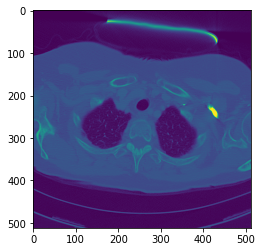

In [71]:
plt.imshow(vol_arr[12])

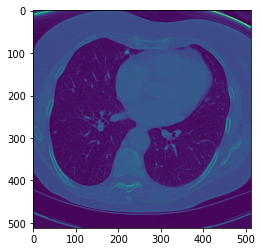

In [73]:
plt.imshow(vol_arr[54])

**NOTE: ** More on CT scans and medical Images later in the book

## Tabular Data